In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from datetime import datetime

### 데이터셋 로드

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/rusita-ai/pyData/master/product.csv')
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15009 entries, 0 to 15008
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           15009 non-null  object 
 1   meanPriceEach  15009 non-null  float64
 2   totalOrder     15009 non-null  float64
 3   orderType_1    15009 non-null  float64
 4   orderType_2    15009 non-null  float64
 5   orderType_3    15009 non-null  float64
 6   totalBundle    15009 non-null  float64
 7   bundleType_1   15009 non-null  float64
 8   bundleType_2   15009 non-null  float64
 9   customerType   15009 non-null  object 
 10  FY             15009 non-null  int64  
 11  Country        15009 non-null  int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 1.4+ MB


### 빈도 분석

In [ ]:
DF.customerType.value_counts()

Offline    7506
Online     7503
Name: customerType, dtype: int64

### 분포 시각화

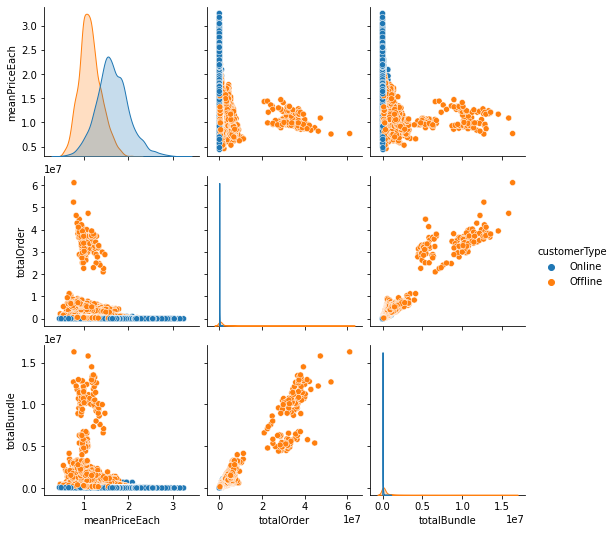

In [ ]:
sns.pairplot(hue = 'customerType', data = DF[['meanPriceEach', 'totalOrder', 'totalBundle', 'customerType']])
plt.show()

### logisticRegression 모델링 함수

In [ ]:
def logisticRegression(model_id, X, y, ts = 0.3, rs = 2045):
  # split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts, random_state = rs)

  # model
  Model_lr = LogisticRegression()
  Model_lr.fit(X_train, y_train)

  # predict
  y_hat = Model_lr.predict(X_test)

  score_ac = accuracy_score(y_test, y_hat)
  score_f1 = f1_score(y_test, y_hat, average = None)

  return { 'model_id' : model_id, 'accuracy_score' : score_ac, 'f1_score' : score_f1 }

### decisionTree 모델링 함수

In [ ]:
def decisionTree(model_id, X, y, md = 3, ts = 0.3, rs = 2045, visualFeature = False, visualModel = False):
  # split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts, random_state = rs)

  # model
  Model_dt = DecisionTreeClassifier(max_depth = md, random_state=2045)
  Model_dt.fit(X_train, y_train)

  # predict
  y_hat = Model_dt.predict(X_test)

  if visualFeature:
    plt.figure(figsize = (9, 6))
    sns.barplot(Model_dt.feature_importances_, X.columns)
    plt.title('Feature Importance')
    plt.show()
  if visualModel:
    g = graphviz.Source(export_graphviz(Model_dt, class_names = (['Offline', 'Online']), feature_names = X.columns, filled = True))
    display(g)

  score_ac = accuracy_score(y_test, y_hat)
  score_f1 = f1_score(y_test, y_hat, average = None)

  return { 'model_id' : model_id, 'max_depth': md, 'accuracy_score' : score_ac, 'f1_score' : score_f1 }

randomForest 모델링 함수

In [ ]:
def randomForest(model_id, X, y, n_est = 100, mf = 'auto', md = None, ts = 0.3, rs = 2045, visualFeature = False):
  # split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts, random_state = rs)

  # model
  Model_rf = RandomForestClassifier(n_estimators = n_est, max_features = mf, max_depth = md, random_state = rs)
  Model_rf.fit(X_train, y_train)

  # predict
  y_hat = Model_rf.predict(X_test)

  if visualFeature:
    plt.figure(figsize = (9, 6))
    sns.barplot(Model_rf.feature_importances_, X.columns)
    plt.title('Feature Importance')
    plt.show()

  score_ac = accuracy_score(y_test, y_hat)
  score_f1 = f1_score(y_test, y_hat, average = None)

  return { 'model_id' : model_id, 'n_estimators' : n_est, 'max_features' : mf, 'max_depth' : md, 'accuracy_score' : score_ac, 'f1_score' : score_f1 }

### 데이터셋

In [ ]:
X = DF[['meanPriceEach','totalOrder','orderType_1','orderType_2','orderType_3','totalBundle','bundleType_1','bundleType_2','FY','Country']]
y = DF['customerType']

### Scaling

In [ ]:
scaler = StandardScaler()
DF[['meanPriceEach','totalOrder','orderType_1','orderType_2','orderType_3','totalBundle','bundleType_1','bundleType_2','FY','Country']] = scaler.fit_transform(X)
DF.head()

,Date,meanPriceEach,totalOrder,orderType_1,orderType_2,orderType_3,totalBundle,bundleType_1,bundleType_2,customerType,FY,Country
0,2015-01-04,0.435826,-0.229648,-0.223876,-0.225079,-0.184144,-0.221783,-0.218247,-0.216765,Online,-1.122883,-0.09592
1,2015-01-04,-0.705548,0.504159,0.222739,0.824266,1.365658,0.301085,0.353465,0.139192,Offline,-1.122883,-0.09592
2,2015-01-11,-0.531861,0.433612,0.210786,0.596742,1.457015,0.345009,0.404265,0.161585,Offline,-1.122883,-0.09592
3,2015-01-11,0.336576,-0.227488,-0.220304,-0.220823,-0.188537,-0.223718,-0.219032,-0.222398,Online,-1.122883,-0.09592
4,2015-01-18,0.659138,-0.231251,-0.222797,-0.225015,-0.187008,-0.228830,-0.227005,-0.218172,Online,-1.122883,-0.09592


### 결과를 담을 데이터프레임

In [ ]:
DF_res = pd.DataFrame(data=None, columns=['model_id', 'n_estimators', 'max_features', 'max_depth', 'accuracy_score', 'f1_score'])

### Logistic Regression

In [ ]:
res = logisticRegression('LR-1', DF[['meanPriceEach', 'totalOrder', 'totalBundle']], y)
print(res)
DF_res = DF_res.append(res, ignore_index=True)

{'model_id': 'LR-1', 'accuracy_score': 0.8869642460581835, 'f1_score': array([0.88333715, 0.8903726 ])}


In [ ]:
res = logisticRegression('LR-2', DF[['orderType_1', 'orderType_2', 'orderType_3']], y)
print(res)
DF_res = DF_res.append(res, ignore_index=True)

{'model_id': 'LR-2', 'accuracy_score': 0.8854097268487675, 'f1_score': array([0.8730315 , 0.89558883])}


In [ ]:
res = logisticRegression('LR-3', DF[['bundleType_1', 'bundleType_2']], y)
print(res)
DF_res = DF_res.append(res, ignore_index=True)

{'model_id': 'LR-3', 'accuracy_score': 0.8452143015767266, 'f1_score': array([0.82979243, 0.85807371])}


In [ ]:
res = logisticRegression('LR-4', DF[['meanPriceEach', 'totalOrder', 'orderType_2', 'orderType_3', 'bundleType_1', 'Country']], y)
print(res)
DF_res = DF_res.append(res, ignore_index=True)

{'model_id': 'LR-4', 'accuracy_score': 0.8989562513879635, 'f1_score': array([0.89528193, 0.90238146])}


### Decision Tree

In [ ]:
res = decisionTree('DT-1', X, y, 3)
print(res)
DF_res = DF_res.append(res, ignore_index=True)

{'model_id': 'DT-1', 'max_depth': 3, 'accuracy_score': 0.9475904952254053, 'f1_score': array([0.94891775, 0.94619243])}


In [ ]:
res = decisionTree('DT-2', X, y, 4)
print(res)
DF_res = DF_res.append(res, ignore_index=True)

{'model_id': 'DT-2', 'max_depth': 4, 'accuracy_score': 0.960692871419054, 'f1_score': array([0.96137901, 0.95998191])}


In [ ]:
res = decisionTree('DT-3', X, y, 5)
print(res)
DF_res = DF_res.append(res, ignore_index=True)

{'model_id': 'DT-3', 'max_depth': 5, 'accuracy_score': 0.9782367310681768, 'f1_score': array([0.97804659, 0.9784236 ])}


In [ ]:
res = decisionTree('DT-4', X, y, 6)
print(res)
DF_res = DF_res.append(res, ignore_index=True)

{'model_id': 'DT-4', 'max_depth': 6, 'accuracy_score': 0.9831223628691983, 'f1_score': array([0.9830584 , 0.98318584])}


### Random Forest

In [ ]:
index = 1

### 1. n_estimators를 50, 100, 150, 200, 250으로 설정하여 실행

In [ ]:
for n in [50, 100, 150, 200, 250]:
  model_name = 'RF-' + str(index)
  index += 1
  res = randomForest(model_name, X, y, n_est=n)
  print(res)
  DF_res = DF_res.append(res, ignore_index=True)

{'model_id': 'RF-1', 'n_estimators': 50, 'max_features': 'auto', 'max_depth': None, 'accuracy_score': 0.9940039973351099, 'f1_score': array([0.99395838, 0.99404893])}
{'model_id': 'RF-2', 'n_estimators': 100, 'max_features': 'auto', 'max_depth': None, 'accuracy_score': 0.9942260715078837, 'f1_score': array([0.99418084, 0.9942706 ])}
{'model_id': 'RF-3', 'n_estimators': 150, 'max_features': 'auto', 'max_depth': None, 'accuracy_score': 0.9937819231623363, 'f1_score': array([0.99373321, 0.99382988])}
{'model_id': 'RF-4', 'n_estimators': 200, 'max_features': 'auto', 'max_depth': None, 'accuracy_score': 0.9940039973351099, 'f1_score': array([0.99395838, 0.99404893])}
{'model_id': 'RF-5', 'n_estimators': 250, 'max_features': 'auto', 'max_depth': None, 'accuracy_score': 0.9935598489895625, 'f1_score': array([0.99351085, 0.99360811])}


### 2. n_estimators를 100으로 고정하고, max_features를 2, 3, 4, 5, 6으로 설정하여 실행

In [ ]:
for n in [2, 3, 4, 5, 6] :
  model_name = 'RF-' + str(index)
  index += 1
  res = randomForest(model_name, X, y, n_est=100, mf=n)
  print(res)
  DF_res = DF_res.append(res, ignore_index=True)

{'model_id': 'RF-6', 'n_estimators': 100, 'max_features': 2, 'max_depth': None, 'accuracy_score': 0.9937819231623363, 'f1_score': array([0.9937276 , 0.99383531])}
{'model_id': 'RF-7', 'n_estimators': 100, 'max_features': 3, 'max_depth': None, 'accuracy_score': 0.9942260715078837, 'f1_score': array([0.99418084, 0.9942706 ])}
{'model_id': 'RF-8', 'n_estimators': 100, 'max_features': 4, 'max_depth': None, 'accuracy_score': 0.9937819231623363, 'f1_score': array([0.99373602, 0.99382716])}
{'model_id': 'RF-9', 'n_estimators': 100, 'max_features': 5, 'max_depth': None, 'accuracy_score': 0.9935598489895625, 'f1_score': array([0.99351955, 0.99359965])}
{'model_id': 'RF-10', 'n_estimators': 100, 'max_features': 6, 'max_depth': None, 'accuracy_score': 0.9928936264712414, 'f1_score': array([0.99284436, 0.99294221])}


### 3. n_estimators를 100, max_features를 3으로 고정하고, max_depth를 5, 10, 15, 20, 25으로 설정하여 실행

In [ ]:
for n in [5, 10, 15, 20, 25] :
  model_name = 'RF-' + str(index)
  index += 1
  res = randomForest(model_name, X, y, n_est=100, mf=3, md=n)
  print(res)
  DF_res = DF_res.append(res, ignore_index=True)

{'model_id': 'RF-11', 'n_estimators': 100, 'max_features': 3, 'max_depth': 5, 'accuracy_score': 0.9786808794137242, 'f1_score': array([0.97878922, 0.97857143])}
{'model_id': 'RF-12', 'n_estimators': 100, 'max_features': 3, 'max_depth': 10, 'accuracy_score': 0.9926715522984677, 'f1_score': array([0.9926191 , 0.99272326])}
{'model_id': 'RF-13', 'n_estimators': 100, 'max_features': 3, 'max_depth': 15, 'accuracy_score': 0.9933377748167888, 'f1_score': array([0.99328859, 0.99338624])}
{'model_id': 'RF-14', 'n_estimators': 100, 'max_features': 3, 'max_depth': 20, 'accuracy_score': 0.9942260715078837, 'f1_score': array([0.99418084, 0.9942706 ])}
{'model_id': 'RF-15', 'n_estimators': 100, 'max_features': 3, 'max_depth': 25, 'accuracy_score': 0.9942260715078837, 'f1_score': array([0.99418084, 0.9942706 ])}


### 성능 평가 결과 비교

In [ ]:
display(DF_res)

,model_id,n_estimators,max_features,max_depth,accuracy_score,f1_score
0,LR-1,NaN,NaN,NaN,0.886964,"[0.8833371533348614, 0.8903726039198793]"
1,LR-2,NaN,NaN,NaN,0.885410,"[0.8730314960629922, 0.8955888304330231]"
2,LR-3,NaN,NaN,NaN,0.845214,"[0.8297924297924298, 0.8580737120749339]"
3,LR-4,NaN,NaN,NaN,0.898956,"[0.8952819332566168, 0.9023814632053208]"
4,DT-1,NaN,NaN,3,0.947590,"[0.9489177489177488, 0.9461924304605563]"
5,DT-2,NaN,NaN,4,0.960693,"[0.9613790093825005, 0.959981912728917]"
6,DT-3,NaN,NaN,5,0.978237,"[0.9780465949820788, 0.9784236019374725]"
7,DT-4,NaN,NaN,6,0.983122,"[0.983058403923317, 0.9831858407079647]"
8,RF-1,50.0,auto,None,0.994004,"[0.993958379950772, 0.9940489310116817]"
9,RF-2,100.0,auto,None,0.994226,"[0.9941808415398388, 0.9942706037902159]"


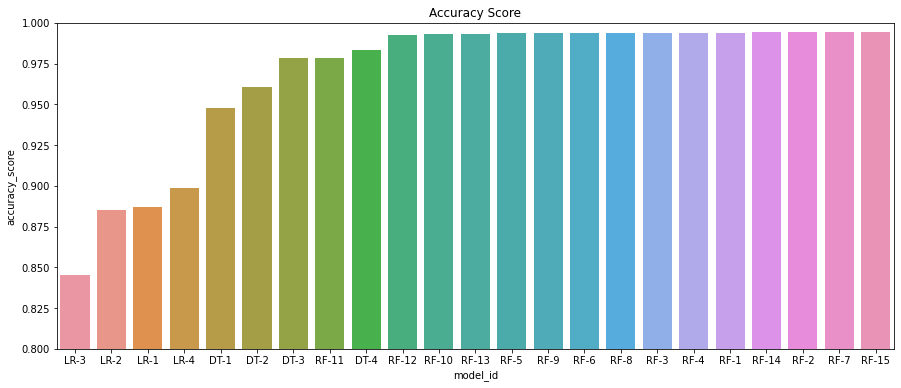

In [ ]:
plt.figure(figsize = (15, 6))
DF_res_sort = DF_res.sort_values(by='accuracy_score')
sns.barplot(x = DF_res_sort.model_id, y = DF_res_sort.accuracy_score)
plt.title('Accuracy Score')
plt.ylim([0.8, 1.0])
plt.show()

### 가장 좋은 성능  - RF-2, RF-7, RF-15 모델
### estimators : 100(default), max_features : 3(auto), max_depth : 20(none)
### accuracy_score  - 0.9942260715078837

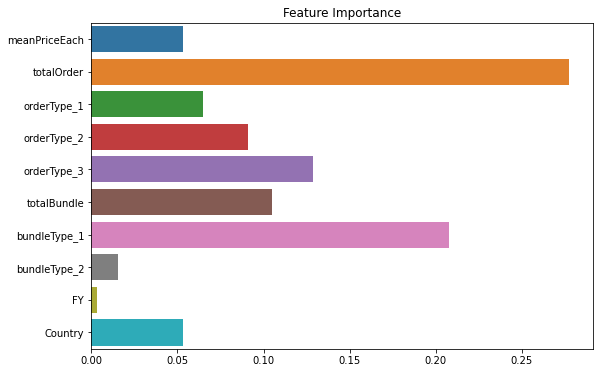

{'model_id': 'Best', 'n_estimators': 100, 'max_features': 3, 'max_depth': 20, 'accuracy_score': 0.9942260715078837, 'f1_score': array([0.99418084, 0.9942706 ])}


In [ ]:
res = randomForest('Best', X, y, n_est=100, mf=3, md=20, visualFeature=True)
print(res)

### GridSearchCV 적용

In [ ]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

Model_rf = RandomForestClassifier()

params = {'n_estimators':[100, 200, 300],
          'max_features':[2, 3, 4],
          'max_depth':[10, 15, 20, 25],
          'random_state':[2045]}

grid_cv = GridSearchCV(Model_rf,
            param_grid = params,
            scoring = 'accuracy',
            cv = KFold(n_splits = 5,
                       random_state = 2045),
            refit = True,
            n_jobs = -1)
start_time = datetime.now()
grid_cv.fit(X_train, y_train)
end_time = datetime.now()

print('Elapsed Time : ', end_time - start_time)

Elapsed Time :  0:05:58.441885


In [ ]:
grid_cv.best_params_

{'max_depth': 20, 'max_features': 2, 'n_estimators': 300, 'random_state': 2045}

In [ ]:
Model_CV = grid_cv.best_estimator_

In [ ]:
y_hat = Model_CV.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_hat))
print(accuracy_score(y_test, y_hat))

[[2218    9]
 [  19 2257]]
0.9937819231623363


### GridSearchCV 적용시에는 위의 성능결과와는 달리
### estimators : 300, max_features : 2, max_depth : 20 으로 나옴
### accuracy_score -  0.9937819231623363

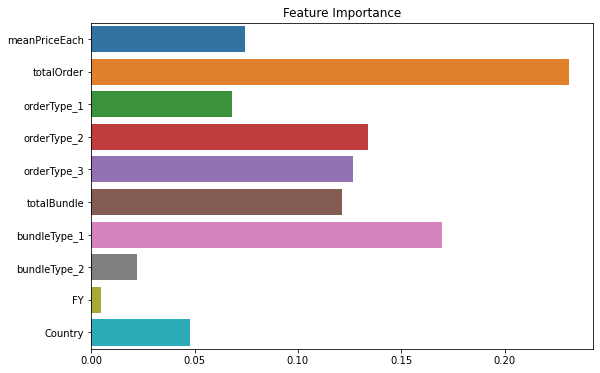

{'model_id': 'Best', 'n_estimators': 300, 'max_features': 2, 'max_depth': 20, 'accuracy_score': 0.9937819231623363, 'f1_score': array([0.9937276 , 0.99383531])}


In [ ]:
res = randomForest('Best', X, y, n_est=300, mf=2, md=20, visualFeature=True)
print(res)